In [1]:
import numpy as np
import os
import torch

from datetime import datetime
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision import transforms

import amphibian.preprocess.preprocessing as preproc

from amphibian.fetch.reader import AmphibianReader
from amphibian.preprocess.train_test_split import TrainTestSplit
from amphibian.architectures import SoftmaxRegressionModel, RNNModel, LSTMModel, AttentionModel
from amphibian.train import SingleTrainer
from amphibian.visual import ConfusionMatrix, MAVI

In [2]:
ar = AmphibianReader('data/all_values/banking',
                     datetime(2010, 7, 16),
                     datetime(2018, 6, 10))

_ = ar.create_torch()

In [3]:
train_test_splits = [TrainTestSplit(ar, input_reg='ASIA_PACIFIC', pred_reg='EMEIA', int_start=0, int_end=ar.torch['AMERICA'].shape[0], train_size=0.9465),
                     TrainTestSplit(ar, input_reg='ASIA_PACIFIC', pred_reg='AMERICA', int_start=0, int_end=ar.torch['AMERICA'].shape[0], train_size=0.9465),
                     TrainTestSplit(ar, input_reg='EMEIA', pred_reg='AMERICA', int_start=0, int_end=ar.torch['AMERICA'].shape[0], train_size=0.9465)]

## RNN

In [4]:
rnn_params = {'learning_rate': 0.003956062, 'batch_size': 32, 'seq_len': 25, 'hidden_size': 8, 'dropout': 0.367072568}
learning_rate = rnn_params.pop('learning_rate')
batch_size = rnn_params['batch_size']
seq_len = rnn_params['seq_len']
model_params = {**rnn_params, 
                **{'input_size': 60,
                   'n_outputs': 3,
                   'num_layers': 2}}
model = RNNModel(**model_params)
model.load_state_dict(torch.load('./data/model_pickles/rnn.pth', map_location=torch.device('cuda:0')))
model.to('cuda')

RNNModel(
  (rnn): RNN(60, 8, num_layers=2, dropout=0.367072568)
  (fc): Linear(in_features=8, out_features=3, bias=True)
)

In [5]:
timeser_datasets = [
    preproc.TimeSeriesDataset(
        tts, int_len=seq_len,
        transform=transforms.Compose([
            preproc.FillNaN(), preproc.Normalizing(),
            preproc.DummyFillNaN(), preproc.Formatting(),
            preproc.FormattingY()
        ])
    )
    for tts in train_test_splits
]

tsds = torch.utils.data.ConcatDataset(timeser_datasets)
vds = torch.utils.data.ConcatDataset(
    [preproc.ValidDataset(td) for td in timeser_datasets]
)

d:\gsn-projekt\venv\lib\site-packages\torch\tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
d:\gsn-projekt\venv\lib\site-packages\numpy\lib\nanfunctions.py:1503: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


In [6]:
dl = DataLoader(vds, batch_size=len(vds))
for i, batch in enumerate(dl):
    y_true = batch['test_y'].cpu().numpy()
    model.eval()
    with torch.no_grad():
        y_pred = torch.argmax(model(batch['test_obs'].permute(1, 0, 2)), 1).cpu().numpy()

In [7]:
confmat = confusion_matrix(y_true, y_pred)

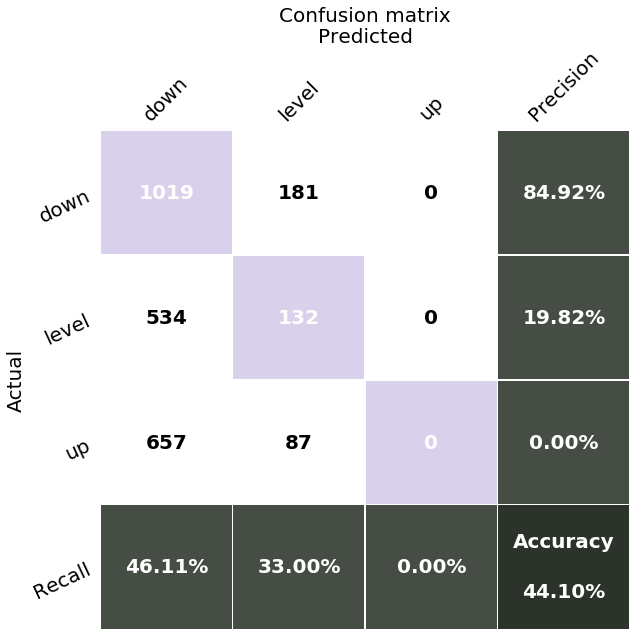

In [8]:
ConfusionMatrix(confmat, ['down', 'level', 'up']).plot(fontsize=20)

## LSTM

In [15]:
lstm_params = {'learning_rate': 0.008749082485073683, 'batch_size': 64, 'seq_len': 21, 'hidden_size': 6, 'dropout': 0.4845307361568673}
learning_rate = lstm_params.pop('learning_rate')
batch_size = lstm_params['batch_size']
seq_len = lstm_params['seq_len']
model_params = {**lstm_params, 
                **{'input_size': 60,
                   'n_outputs': 3,
                   'num_layers': 2}}
model = LSTMModel(**model_params)
model.load_state_dict(torch.load('./data/model_pickles/lstm.pth', map_location=torch.device('cuda:0')))
model.to('cuda')

LSTMModel(
  (lstm): LSTM(60, 6, num_layers=2, dropout=0.4845307361568673)
  (fc): Linear(in_features=6, out_features=3, bias=True)
)

In [16]:
timeser_datasets = [
    preproc.TimeSeriesDataset(
        tts, int_len=seq_len,
        transform=transforms.Compose([
            preproc.FillNaN(), preproc.Normalizing(),
            preproc.DummyFillNaN(), preproc.Formatting(),
            preproc.FormattingY()
        ])
    )
    for tts in train_test_splits
]

tsds = torch.utils.data.ConcatDataset(timeser_datasets)
vds = torch.utils.data.ConcatDataset(
    [preproc.ValidDataset(td) for td in timeser_datasets]
)

d:\gsn-projekt\venv\lib\site-packages\torch\tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
d:\gsn-projekt\venv\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [17]:
dl = DataLoader(vds, batch_size=len(vds))
for i, batch in enumerate(dl):
    y_true = batch['test_y'].cpu().numpy()
    model.eval()
    with torch.no_grad():
        y_pred = torch.argmax(model(batch['test_obs'].permute(1, 0, 2)), 1).cpu().numpy()

In [18]:
confmat = confusion_matrix(y_true, y_pred)

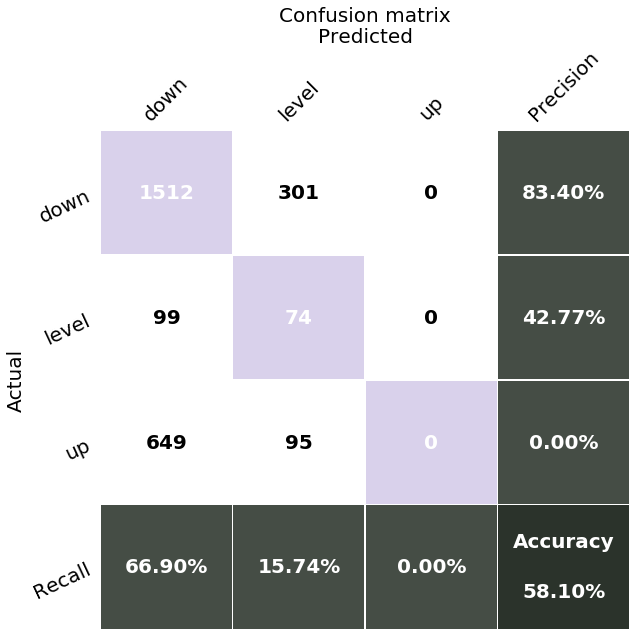

In [19]:
ConfusionMatrix(confmat, ['down', 'level', 'up']).plot(fontsize=20)

## Attention

In [23]:
attn_params = {'learning_rate': 0.004139811848108426, 'batch_size': 64, 'seq_len': 24, 'hidden_size': 10, 'dropout': 0.0067987573823941605}
learning_rate = attn_params.pop('learning_rate')
batch_size = attn_params['batch_size']
seq_len = attn_params['seq_len']
model_params = {**attn_params, 
                **{'input_size': 60,
                   'n_outputs': 3,
                   'num_layers': 2,
                   'recurrent_type': 'lstm',
                   'alignment': 'ffnn'}}
model = AttentionModel(**model_params)
model.load_state_dict(torch.load('./data/model_pickles/attention.pth', map_location=torch.device('cuda:0')))
model.to('cuda')

AttentionModel(
  (recurrent_pre): LSTM(60, 10, num_layers=2, dropout=0.0067987573823941605)
  (recurrent_cell_post): LSTMCell(10, 10)
  (fc): Linear(in_features=10, out_features=3, bias=True)
)

In [24]:
timeser_datasets = [
    preproc.TimeSeriesDataset(
        tts, int_len=seq_len,
        transform=transforms.Compose([
            preproc.FillNaN(), preproc.Normalizing(),
            preproc.DummyFillNaN(), preproc.Formatting(),
            preproc.FormattingY()
        ])
    )
    for tts in train_test_splits
]

tsds = torch.utils.data.ConcatDataset(timeser_datasets)
vds = torch.utils.data.ConcatDataset(
    [preproc.ValidDataset(td) for td in timeser_datasets]
)

d:\gsn-projekt\venv\lib\site-packages\torch\tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
d:\gsn-projekt\venv\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [25]:
dl = DataLoader(vds, batch_size=len(vds))
for i, batch in enumerate(dl):
    y_true = batch['test_y'].cpu().numpy()
    model.eval()
    with torch.no_grad():
        y_pred = torch.argmax(model(batch['test_obs'].permute(1, 0, 2)), 1).cpu().numpy()

In [26]:
confmat = confusion_matrix(y_true, y_pred)

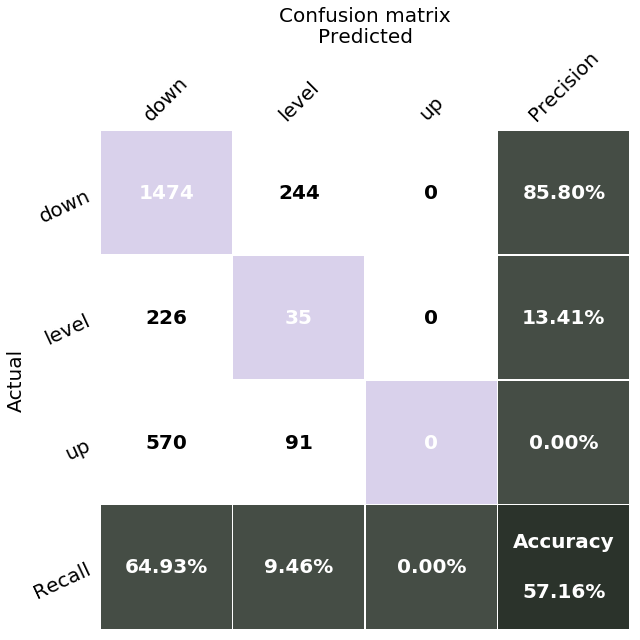

In [27]:
ConfusionMatrix(confmat, ['down', 'level', 'up']).plot(fontsize=20)

## LSTM by Region

In [28]:
lstm_params = {'learning_rate': 0.008749082485073683, 'batch_size': 64, 'seq_len': 21, 'hidden_size': 6, 'dropout': 0.4845307361568673}
learning_rate = lstm_params.pop('learning_rate')
batch_size = lstm_params['batch_size']
seq_len = lstm_params['seq_len']
model_params = {**lstm_params, 
                **{'input_size': 60,
                   'n_outputs': 3,
                   'num_layers': 2}}
model = LSTMModel(**model_params)
model.load_state_dict(torch.load('./data/model_pickles/lstm.pth', map_location=torch.device('cuda:0')))
model.to('cuda')

LSTMModel(
  (lstm): LSTM(60, 6, num_layers=2, dropout=0.4845307361568673)
  (fc): Linear(in_features=6, out_features=3, bias=True)
)

In [29]:
timeser_datasets = [
    preproc.TimeSeriesDataset(
        tts, int_len=seq_len,
        transform=transforms.Compose([
            preproc.FillNaN(), preproc.Normalizing(),
            preproc.DummyFillNaN(), preproc.Formatting(),
            preproc.FormattingY()
        ])
    )
    for tts in train_test_splits
]

tsds = torch.utils.data.ConcatDataset(timeser_datasets)
vds = torch.utils.data.ConcatDataset(
    [preproc.ValidDataset(td) for td in timeser_datasets]
)

In [37]:
dl = DataLoader(vds, batch_size=int(len(vds) / 3))
for i, batch in enumerate(dl):
    if i == 2:
        y_true = batch['test_y'].cpu().numpy()
        model.eval()
        with torch.no_grad():
            y_pred = torch.argmax(model(batch['test_obs'].permute(1, 0, 2)), 1).cpu().numpy()

In [38]:
confmat = confusion_matrix(y_true, y_pred)

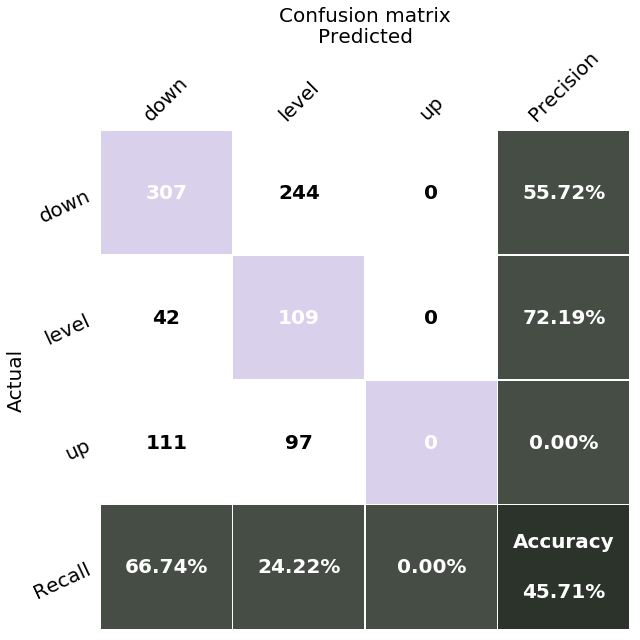

In [39]:
ConfusionMatrix(confmat, ['down', 'level', 'up']).plot(fontsize=20)

# MAVI

In [41]:
dl = DataLoader(vds, batch_size=int(len(vds) / 30))
for i, batch in enumerate(dl):
    print('Region {}'.format(i // 10 + 1))
    print('Company {}'.format((i % 10 + 1)))
    y_true = batch['test_y'].cpu().numpy()
    model.eval()
    with torch.no_grad():
        y_pred = torch.argmax(model(batch['test_obs'].permute(1, 0, 2)), 1).cpu().numpy()
    print(np.sum(y_true == y_pred) / (len(vds) / 30))

Region 1
Company 1
0.6923076923076923
Region 1
Company 2
0.6813186813186813
Region 1
Company 3
0.6043956043956044
Region 1
Company 4
0.5714285714285714
Region 1
Company 5
0.7142857142857143
Region 1
Company 6
0.6373626373626373
Region 1
Company 7
0.5384615384615384
Region 1
Company 8
0.6153846153846154
Region 1
Company 9
0.6153846153846154
Region 1
Company 10
0.7032967032967034
Region 2
Company 1
0.6153846153846154
Region 2
Company 2
0.6043956043956044
Region 2
Company 3
0.5934065934065934
Region 2
Company 4
0.6153846153846154
Region 2
Company 5
0.5714285714285714
Region 2
Company 6
0.5164835164835165
Region 2
Company 7
0.6923076923076923
Region 2
Company 8
0.5824175824175825
Region 2
Company 9
0.5604395604395604
Region 2
Company 10
0.6043956043956044
Region 3
Company 1
0.43956043956043955
Region 3
Company 2
0.42857142857142855
Region 3
Company 3
0.42857142857142855
Region 3
Company 4
0.4065934065934066
Region 3
Company 5
0.46153846153846156
Region 3
Company 6
0.5054945054945055
Region

In [46]:
os.listdir('./data/all_values/banking/AMERICA')

['BAC', 'BMO', 'C', 'CM', 'GS', 'JPM', 'MS', 'RY', 'TD', 'WFC']

In [43]:
mavi_reg_1 = MAVI(model,
    preproc.TimeSeriesDataset(
    train_test_splits[0], int_len=seq_len,
    transform=transforms.Compose([
        preproc.FillNaN(), preproc.Normalizing(),
        preproc.DummyFillNaN(), preproc.Formatting(),
        preproc.FormattingY()
    ])
), obs_names = ['0939.HK',
 '1288.HK',
 '1398.HK',
 '1988.HK',
 '3328.HK',
 '3988.HK',
 '600000.SS',
 '8306.T',
 '8316.T',
 '8411.T'], y_names=['ACA.PA',
 'BARC.L',
 'BNP.SG',
 'DBK.DE',
 'GLE.PA',
 'HSBA.L',
 'ING.PA',
 'LLOY.L',
 'SAN.MC',
 'UCG.MI'])

In [44]:
mavi_reg_1.compute_losses()

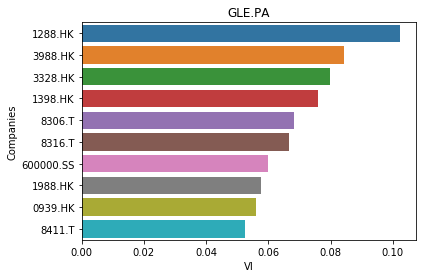

In [45]:
mavi_reg_1.plot_mavi(4)

In [49]:
mavi_reg_2 = MAVI(model,
    preproc.TimeSeriesDataset(
    train_test_splits[1], int_len=seq_len,
    transform=transforms.Compose([
        preproc.FillNaN(), preproc.Normalizing(),
        preproc.DummyFillNaN(), preproc.Formatting(),
        preproc.FormattingY()
    ])
), obs_names = ['0939.HK',
 '1288.HK',
 '1398.HK',
 '1988.HK',
 '3328.HK',
 '3988.HK',
 '600000.SS',
 '8306.T',
 '8316.T',
 '8411.T'], y_names=['BAC', 'BMO', 'C', 'CM', 'GS', 'JPM', 'MS', 'RY', 'TD', 'WFC'])

d:\gsn-projekt\venv\lib\site-packages\torch\tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [50]:
mavi_reg_2.compute_losses()

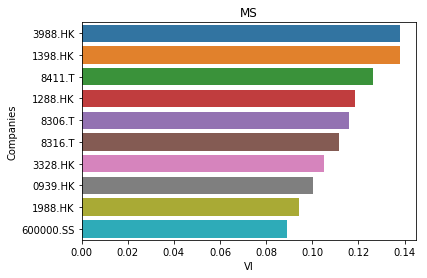

In [51]:
mavi_reg_2.plot_mavi(6)

In [53]:
mavi_reg_3 = MAVI(model,
    preproc.TimeSeriesDataset(
    train_test_splits[2], int_len=seq_len,
    transform=transforms.Compose([
        preproc.FillNaN(), preproc.Normalizing(),
        preproc.DummyFillNaN(), preproc.Formatting(),
        preproc.FormattingY()
    ])
), obs_names = ['ACA.PA',
 'BARC.L',
 'BNP.SG',
 'DBK.DE',
 'GLE.PA',
 'HSBA.L',
 'ING.PA',
 'LLOY.L',
 'SAN.MC',
 'UCG.MI'], y_names=['BAC', 'BMO', 'C', 'CM', 'GS', 'JPM', 'MS', 'RY', 'TD', 'WFC'])

d:\gsn-projekt\venv\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
d:\gsn-projekt\venv\lib\site-packages\torch\tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [54]:
mavi_reg_3.compute_losses()

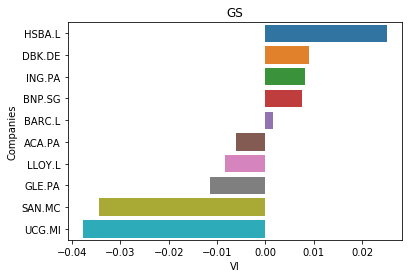

In [55]:
mavi_reg_3.plot_mavi(4)